In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

from ipywidgets import widgets
from IPython.display import display

from matplotlib import animation
from JSAnimation.IPython_display import display_animation
from time import gmtime, strftime
import random
import cv2
import sys
import numpy as np 
import wandb
import gym
import tensorflow_docs.vis.embed as embed


In [3]:
# based on the tutorial from http://www.pinchofintelligence.com/openai-gym-part-3-playing-space-invaders-deep-reinforcement-learning/
# -----------------------------
# File: Deep Q-Learning Algorithm
# Author: Flood Sung
# Date: 2016.3.21
# -----------------------------

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import numpy as np 
import random
from collections import deque 

# Hyper Parameters:
FRAME_PER_ACTION = 1
GAMMA = 0.95 # decay rate of past observations
OBSERVE = 50000. # timesteps to observe before training
EXPLORE = 1000000. # frames over which to anneal epsilon
FINAL_EPSILON = 0.1#0.001 # final value of epsilon
INITIAL_EPSILON = 1.0#0.01 # starting value of epsilon
REPLAY_MEMORY = 40000 # number of previous transitions to remember
BATCH_SIZE = 32 # size of minibatch
UPDATE_TIME = 10000

class BrainDQN:

    def __init__(self,actions):
        # init a list to store the cumulative rewards per episode
        self.rewards_cum_sum = []
        # init replay memory
        self.replayMemory = deque()
        # init some parameters
        self.timeStep = 0
        self.epsilon = INITIAL_EPSILON
        self.actions = actions
        # init Q network
        self.stateInput,self.QValue,self.W_conv1,self.b_conv1,self.W_conv2,self.b_conv2,self.W_conv3,self.b_conv3,self.W_fc1,self.b_fc1,self.W_fc2,self.b_fc2 = self.createQNetwork()

        # init Target Q Network - same architectue as Q network but separate weights
        self.stateInputT,self.QValueT,self.W_conv1T,self.b_conv1T,self.W_conv2T,self.b_conv2T,self.W_conv3T,self.b_conv3T,self.W_fc1T,self.b_fc1T,self.W_fc2T,self.b_fc2T = self.createQNetwork()
        # function used to copy the weights from the Q network to Q Target network, triggered every UPDATE_TIME step
        self.copyTargetQNetworkOperation = [self.W_conv1T.assign(self.W_conv1),self.b_conv1T.assign(self.b_conv1),self.W_conv2T.assign(self.W_conv2),self.b_conv2T.assign(self.b_conv2),self.W_conv3T.assign(self.W_conv3),self.b_conv3T.assign(self.b_conv3),self.W_fc1T.assign(self.W_fc1),self.b_fc1T.assign(self.b_fc1),self.W_fc2T.assign(self.W_fc2),self.b_fc2T.assign(self.b_fc2)]

        self.createTrainingMethod()

        # saving and loading networks
        self.saver = tf.train.Saver()
        self.session = tf.InteractiveSession()
        self.session.run(tf.global_variables_initializer())
        checkpoint = tf.train.get_checkpoint_state("./savedweights")
        if checkpoint and checkpoint.model_checkpoint_path:
            self.saver.restore(self.session, checkpoint.model_checkpoint_path)
            print("Successfully loaded:", checkpoint.model_checkpoint_path)
        else:
            print("Could not find old network weights")


    def createQNetwork(self):
        # network weights
        W_conv1 = self.weight_variable([8,8,4,32])
        b_conv1 = self.bias_variable([32])

        W_conv2 = self.weight_variable([4,4,32,64])
        b_conv2 = self.bias_variable([64])

        W_conv3 = self.weight_variable([3,3,64,64])
        b_conv3 = self.bias_variable([64])

        W_fc1 = self.weight_variable([3136,512])
        b_fc1 = self.bias_variable([512])

        W_fc2 = self.weight_variable([512,self.actions])
        b_fc2 = self.bias_variable([self.actions])

        # input layer

        stateInput = tf.placeholder("float",[None,84,84,4])

        # hidden layers
        h_conv1 = tf.nn.relu(self.conv2d(stateInput,W_conv1,4) + b_conv1)
        #h_pool1 = self.max_pool_2x2(h_conv1)

        h_conv2 = tf.nn.relu(self.conv2d(h_conv1,W_conv2,2) + b_conv2)

        h_conv3 = tf.nn.relu(self.conv2d(h_conv2,W_conv3,1) + b_conv3)
        h_conv3_shape = h_conv3.get_shape().as_list()
        print("dimension:",h_conv3_shape[1]*h_conv3_shape[2]*h_conv3_shape[3])
        h_conv3_flat = tf.reshape(h_conv3,[-1,3136])
        h_fc1 = tf.nn.relu(tf.matmul(h_conv3_flat,W_fc1) + b_fc1)

        # Q Value layer
        QValue = tf.matmul(h_fc1,W_fc2) + b_fc2

        return stateInput,QValue,W_conv1,b_conv1,W_conv2,b_conv2,W_conv3,b_conv3,W_fc1,b_fc1,W_fc2,b_fc2

    def copyTargetQNetwork(self):
        self.session.run(self.copyTargetQNetworkOperation)

    # this function calculates the loss (MSE) and minimizes it using RMSProp
    def createTrainingMethod(self):
        self.actionInput = tf.placeholder("float",[None,self.actions])
        self.yInput = tf.placeholder("float", [None]) 
        Q_Action = tf.reduce_sum(tf.multiply(self.QValue, self.actionInput), reduction_indices = 1)
        self.cost = tf.reduce_mean(tf.square(self.yInput - Q_Action))
        self.trainStep = tf.train.RMSPropOptimizer(0.00025,0.99,0.0,1e-6).minimize(self.cost)


    def trainQNetwork(self):

        # Step 1: obtain random minibatch from replay memory
        minibatch = random.sample(self.replayMemory,BATCH_SIZE)
        state_batch = [data[0] for data in minibatch]
        action_batch = [data[1] for data in minibatch]
        reward_batch = [data[2] for data in minibatch]
        nextState_batch = [data[3] for data in minibatch]

        # Step 2: calculate y 
        y_batch = []
        QValue_batch = self.QValueT.eval(feed_dict={self.stateInputT:nextState_batch})
        for i in range(0,BATCH_SIZE):
            terminal = minibatch[i][4]
            if terminal:
                y_batch.append(reward_batch[i])
            else:
                y_batch.append(reward_batch[i] + GAMMA * np.max(QValue_batch[i]))

        self.trainStep.run(feed_dict={
            self.yInput : y_batch,
            self.actionInput : action_batch,
            self.stateInput : state_batch
            })

        # save network every 100000 iteration
        if self.timeStep % 10000 == 0:
            self.saver.save(self.session, './savedweights/network' + '-dqn', global_step = self.timeStep)

        if self.timeStep % UPDATE_TIME == 0:
            self.copyTargetQNetwork()

    def setPerception(self,nextObservation,action,reward,terminal):
        newState = np.append(nextObservation,self.currentState[:,:,1:],axis = 2)
        self.replayMemory.append((self.currentState,action,reward,newState,terminal))
        if len(self.replayMemory) > REPLAY_MEMORY:
            self.replayMemory.popleft()
        if self.timeStep > OBSERVE:
            # Train the network
            self.trainQNetwork()

        # print info
        state = ""
        if self.timeStep <= OBSERVE:
            state = "observe"
        elif self.timeStep > OBSERVE and self.timeStep <= OBSERVE + EXPLORE:
            state = "explore"
        else:
            state = "train"
        if self.timeStep % 10000 == 0:
            print("TIMESTEP", self.timeStep, "/ STATE", state, "/ EPSILON", self.epsilon)

        self.currentState = newState
        self.timeStep += 1

    def getAction(self):
        QValue = self.QValue.eval(feed_dict= {self.stateInput:[self.currentState]})[0]
        action = np.zeros(self.actions)
        action_index = 0
        if self.timeStep % FRAME_PER_ACTION == 0:
            if random.random() <= self.epsilon:
                action_index = random.randrange(self.actions)
                action[action_index] = 1
            else:
                action_index = np.argmax(QValue)
                action[action_index] = 1
        else:
            action[0] = 1 # do nothing

        # change episilon
        if self.epsilon > FINAL_EPSILON and self.timeStep > OBSERVE:
            self.epsilon -= (INITIAL_EPSILON - FINAL_EPSILON)/EXPLORE

        return action

    def setInitState(self,observation):
        self.currentState = np.stack((observation, observation, observation, observation), axis = 2)

    def weight_variable(self,shape):
        initial = tf.random.truncated_normal(shape, stddev = 0.01)
        return tf.Variable(initial)

    def bias_variable(self,shape):
        initial = tf.constant(0.01, shape = shape)
        return tf.Variable(initial)

    def conv2d(self,x, W, stride):
        return tf.nn.conv2d(x, W, strides = [1, stride, stride, 1], padding = "VALID")

    def max_pool_2x2(self,x):
        return tf.nn.max_pool(x, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1], padding = "SAME")

Instructions for updating:
non-resource variables are not supported in the long term


In [4]:
env = gym.make('ALE/SpaceInvaders-v5')
env.reset()
actions = env.action_space.n
brain = BrainDQN(actions)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


dimension: 3136
dimension: 3136
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Could not find old network weights


Before processing: (210, 160, 3)


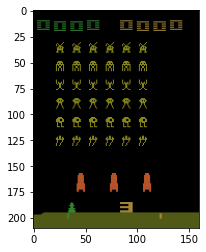

After processing: (84, 84, 1)


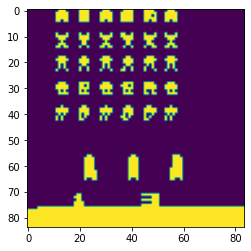

In [5]:
def preprocess(observation):
    observation = cv2.cvtColor(cv2.resize(observation, (84, 110)), cv2.COLOR_BGR2GRAY)
    observation = observation[26:110,:]
    ret, observation = cv2.threshold(observation,1,255,cv2.THRESH_BINARY)
    return np.reshape(observation,(84,84,1))


action0 = 0  # do nothing
observation0, reward0, terminal, info = env.step(action0)
print("Before processing: " + str(np.array(observation0).shape))
plt.imshow(np.array(observation0))
plt.show()
observation0 = preprocess(observation0)
print("After processing: " + str(np.array(observation0).shape))
plt.imshow(np.array(np.squeeze(observation0)))
plt.show()

brain.setInitState(observation0)
brain.currentState = np.squeeze(brain.currentState)

In [7]:
episodic_reward = 0
while True:
    action = brain.getAction()
    actionmax = np.argmax(np.array(action))
    
    nextObservation,reward,terminal, info = env.step(actionmax)
    episodic_reward += reward
    
    if terminal:
        nextObservation = env.reset()
        brain.rewards_cum_sum.append(episodic_reward)
        episodic_reward = 0
    nextObservation = preprocess(nextObservation)
    brain.setPerception(nextObservation,action,reward,terminal)
    if brain.timeStep % 10000 == 0:
        print("Average cumulative reward over the last 100 episodes:", np.mean(brain.rewards_cum_sum[-100:]))

Average cumulative reward over the last 100 episodes: 160.0
TIMESTEP 10000 / STATE observe / EPSILON 1.0
Average cumulative reward over the last 100 episodes: 142.30769230769232
TIMESTEP 20000 / STATE observe / EPSILON 1.0
Average cumulative reward over the last 100 episodes: 142.79661016949152
TIMESTEP 30000 / STATE observe / EPSILON 1.0
Average cumulative reward over the last 100 episodes: 137.43589743589743
TIMESTEP 40000 / STATE observe / EPSILON 1.0
Average cumulative reward over the last 100 episodes: 149.47368421052633
TIMESTEP 50000 / STATE observe / EPSILON 1.0
Average cumulative reward over the last 100 episodes: 149.6
TIMESTEP 60000 / STATE explore / EPSILON 0.9910000000002963
Average cumulative reward over the last 100 episodes: 152.95
TIMESTEP 70000 / STATE explore / EPSILON 0.9820000000005926
Average cumulative reward over the last 100 episodes: 154.35
TIMESTEP 80000 / STATE explore / EPSILON 0.9730000000008889
Average cumulative reward over the last 100 episodes: 155.85


KeyboardInterrupt: 

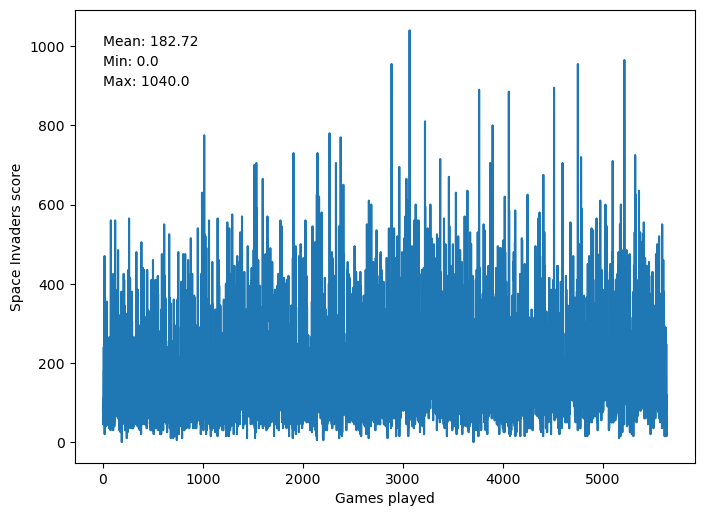

In [23]:
def visualize_learning(model):
    x = [i for i in range(len(model.rewards_cum_sum))]
    y = model.rewards_cum_sum
    avg_ = np.mean(model.rewards_cum_sum)
    min_ = np.min(model.rewards_cum_sum)
    max_ = np.max(model.rewards_cum_sum)
    plt.figure(figsize=(8, 6), dpi=100)
    plt.plot(x,y)
    plt.xlabel("Games played")
    plt.ylabel("Space Invaders score")
    plt.annotate(f"Mean: {round(avg_, 2)}", [1,1000] )
    plt.annotate(f"Min: {round(min_, 2)}", [1,950] )
    plt.annotate(f"Max: {round(max_, 2)}", [1,900] )
    plt.show()
    
visualize_learning(brain)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


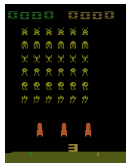

In [60]:
def save_gameplay_to_mp4(frames, model, filename = None):
    """
    Displays a list of frames as a gif, with controls
    """ 
    plt.figure(figsize=(frames[0].shape[1] / 50.0, frames[0].shape[0] / 50.0), dpi = 50)
    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=50)
    Writer = animation.writers['ffmpeg']
    writer = Writer(fps=20, metadata=dict(model=model))
    anim.save(filename, writer = writer)

def play_and_record(model):
    frameshistory = []
    observation = env.reset()
    backupepsilon = model.epsilon
    model.epsilon = 0.01
    done = False
    while not done:
        action = model.getAction()
        actionmax = np.argmax(np.array(action))    
        nextObservation,reward,terminal, info = env.step(actionmax)
        if terminal:
            nextObservation = env.reset()
            done = True
        frameshistory.append(nextObservation)
        nextObservation = preprocess(nextObservation)
        model.setPerception(nextObservation,action,reward,terminal)
    model.epsilon = backupepsilon
    save_gameplay_to_mp4(frameshistory, model, filename = filename)

filename = 'playing_space_invaders.mp4'
model = 'DQN'
frameshistory = []
observation = env.reset()
backupepsilon = brain.epsilon
brain.epsilon = 0.01

play_and_record(brain)